In [1]:
import gym
import os
import numpy as np
import tensorflow as tf
from gym import wrappers
from matplotlib import pyplot as plt

%matplotlib inline

### Hyperparameters

In [2]:
n_obs = 80 * 80        # dimensionality of observations
h = 200                # number of hidden layer neurons
n_actions = 3          # number of available actions
learning_rate = 1e-3
gamma = 0.99           # discount factor for reward
decay = 0.99           # decay rate for RMSProp gradients
save_path = './models/pong.ckpt'

### check dir

In [3]:
if not os.path.exists('./models'):
    os.makedirs('./models')

### gamespace

In [4]:
env = gym.make("Pong-v0")
# env = wrappers.Monitor(env, '/tmp/pong-pg-tensorflow', video_callable=lambda count: count % 300 == 0, force=True)
observation = env.reset()
prev_x = None
xs, rs, ys = [],[],[]
running_reward = None
reward_sum = 0
episode_number = 0

[2017-05-16 02:55:57,729] Making new env: Pong-v0


### initialize model

In [5]:
tf_model = {}

with tf.variable_scope('layer_one', reuse=False):
    xavier_l1 = tf.truncated_normal_initializer(mean=0, stddev=1./np.sqrt(n_obs), dtype=tf.float32)
    tf_model['W1'] = tf.get_variable("W1", [n_obs, h], initializer=xavier_l1)
    
with tf.variable_scope('layer_two', reuse=False):
    xavier_l2 = tf.truncated_normal_initializer(mean=0, stddev=1./np.sqrt(h), dtype=tf.float32)
    tf_model['W2'] = tf.get_variable("W2", [h, n_actions], initializer=xavier_l2)

### tf operations

In [6]:
def tf_discount_rewards(tf_r): # tf_r shape:(game_steps, 1)
    discount_f = lambda a, v: a*gamma + v;
    tf_r_reverse = tf.scan(discount_f, tf.reverse(tf_r, [True, False]))
    tf_discounted_r = tf.reverse(tf_r_reverse, [True, False])
    return tf_discounted_r

In [7]:
def tf_policy_forward(x): # x shape:(1, n_obs)
    h = tf.matmul(x, tf_model['W1'])
    h = tf.nn.relu(h)
    logp = tf.matmul(h, tf_model['W2'])
    p = tf.nn.softmax(logp)
    return p

### downsampling

In [8]:
def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195]    # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0  # erase background (background type 1)
    I[I == 109] = 0  # erase background (background type 2)
    I[I != 0] = 1    # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()

In [9]:
observation, _, _, _ = env.step(2)

(210, 160, 3)


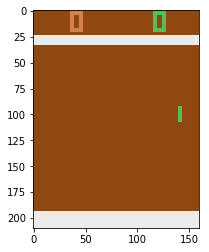

In [10]:
print(observation.shape)
plt.imshow(observation)
plt.show()

(160, 160, 3)


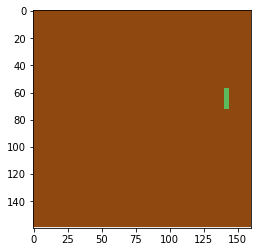

In [11]:
# crop
observation = observation[35:195]
print(observation.shape)
plt.imshow(observation)
plt.show()

(80, 80)


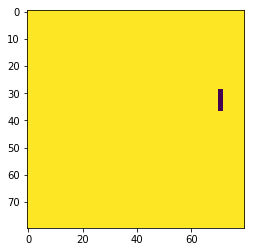

In [12]:
# downsample by factor of 2
observation = observation[::2,::2,0]
print(observation.shape)
plt.imshow(observation)
plt.show()

In [13]:
# 可觀察到144占了多數，應該是背景，為不必要資訊
np.unique(observation, return_counts=True)

(array([ 92, 144], dtype=uint8), array([  16, 6384]))

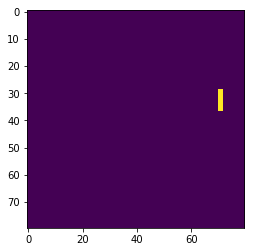

In [14]:
# erase background (background type 1)
observation[observation == 144] = 0
plt.imshow(observation)
plt.show()

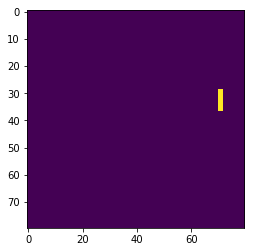

In [15]:
# everything else (paddles, ball) just set to 1
observation[observation != 0] = 1
plt.imshow(observation)
plt.show()

In [16]:
print(np.unique(observation, return_counts=True))
print(observation.shape)

(array([0, 1], dtype=uint8), array([6384,   16]))
(80, 80)


### downsampling (another case)
* 以下只是舉出另外一種erase background，若想重現這段code，請reset env，並不走任何一個action

In [24]:
observation = env.reset()

(210, 160, 3)


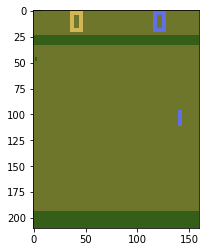

In [25]:
print(observation.shape)
plt.imshow(observation)
plt.show()

(160, 160, 3)


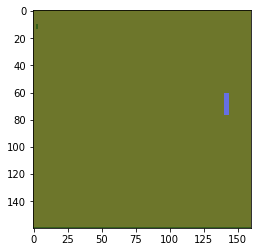

In [26]:
# crop
observation = observation[35:195]
print(observation.shape)
plt.imshow(observation)
plt.show()

In [27]:
observation

array([[[109, 118,  43],
        [109, 118,  43],
        [109, 118,  43],
        ..., 
        [109, 118,  43],
        [109, 118,  43],
        [109, 118,  43]],

       [[109, 118,  43],
        [109, 118,  43],
        [109, 118,  43],
        ..., 
        [109, 118,  43],
        [109, 118,  43],
        [109, 118,  43]],

       [[109, 118,  43],
        [109, 118,  43],
        [109, 118,  43],
        ..., 
        [109, 118,  43],
        [109, 118,  43],
        [109, 118,  43]],

       ..., 
       [[109, 118,  43],
        [109, 118,  43],
        [109, 118,  43],
        ..., 
        [109, 118,  43],
        [109, 118,  43],
        [109, 118,  43]],

       [[109, 118,  43],
        [109, 118,  43],
        [109, 118,  43],
        ..., 
        [109, 118,  43],
        [109, 118,  43],
        [109, 118,  43]],

       [[ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,  24],
        ..., 
        [ 53,  95,  24],
        [ 53,  95,  24],
        [ 53,  95,

(80, 80)


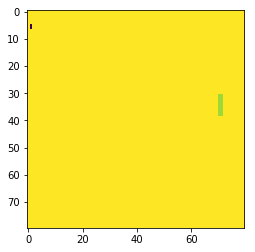

In [28]:
# downsample by factor of 2
observation = observation[::2,::2,0]
print(observation.shape)
plt.imshow(observation)
plt.show()

In [29]:
np.unique(observation, return_counts=True)

(array([ 53, 101, 109], dtype=uint8), array([   2,   16, 6382]))

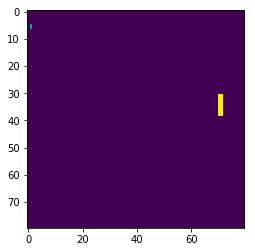

In [30]:
# erase background (background type 2)
observation[observation == 109] = 0
plt.imshow(observation)
plt.show()

### tf placeholders

In [17]:
tf_x = tf.placeholder(dtype=tf.float32, shape=[None, n_obs], name="tf_x")
tf_y = tf.placeholder(dtype=tf.float32, shape=[None, n_actions], name="tf_y")
tf_epr = tf.placeholder(dtype=tf.float32, shape=[None, 1], name="tf_epr")

### tf reward processing

In [18]:
tf_discounted_epr = tf_discount_rewards(tf_epr)
tf_mean, tf_variance = tf.nn.moments(tf_discounted_epr, [0], shift=None, name="reward_moments")
tf_discounted_epr -= tf_mean
tf_discounted_epr /= tf.sqrt(tf_variance + 1e-6)

### tf optimizer op

In [19]:
tf_aprob = tf_policy_forward(tf_x)
loss = tf.nn.l2_loss(tf_y - tf_aprob)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate, decay=decay)
tf_grads = optimizer.compute_gradients(loss, var_list=tf.trainable_variables(), grad_loss=tf_discounted_epr)
train_op = optimizer.apply_gradients(tf_grads)

### tf graph initialization

In [20]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

### try load saved model

In [21]:
saver = tf.train.Saver(tf.global_variables ())
# load_was_success = True
try:
    save_dir = '/'.join(save_path.split('/')[:-1])
    ckpt = tf.train.get_checkpoint_state(save_dir)
    load_path = ckpt.model_checkpoint_path
    saver.restore(sess, load_path)
except:
    print("no save model to load. starting new session")
else:
    print("loaded model: {}".format(load_path))
    saver = tf.train.Saver(tf.global_variables ())
    episode_number = int(load_path.split('-')[-1])

no save model to load. starting new session


### training loop

In [23]:
observation = env.reset()

while True:
    # preprocess the observation, set input to network to be difference image
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(n_obs)
    prev_x = cur_x
    
    # stochastically sample a policy from the network
    feed = {tf_x: np.reshape(x, (1,-1))} # reshape x (80, 80) to (1, 6400)
    aprob = sess.run(tf_aprob, feed) 
    aprob = aprob[0,:] # turn array([[...]]) to array([...]), aprob shape is (1, 3)
    action = np.random.choice(n_actions, p=aprob)
    label = np.zeros_like(aprob)
    label[action] = 1
    
    # step the envirnoment and get new measurements
    # action 1 = 不動, action 2 = 向上, action 3 = 向下
    observation, reward, done, info = env.step(action+1)
    reward_sum += reward
    
    # record game history
    xs.append(x)
    ys.append(label)
    rs.append(reward)
    
    if done:
        # update running reward
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        
        
        # parameter update
        feed = {tf_x: np.vstack(xs), tf_epr: np.vstack(rs), tf_y: np.vstack(ys)}
        _ = sess.run(train_op, feed)
        
        
        # print progress console
        if episode_number % 10 == 0:
            print('ep {}: reward: {}, mean reward: {:3f}'.format(episode_number, reward_sum, running_reward))
        else:
            print('\tep {}: reward: {}'.format(episode_number, reward_sum))
            
        episode_number += 1
        
        
        # reset
        xs, rs, ys = [], [], []
        observation = env.reset()
        reward_sum = 0
        
        
        # save model
        if episode_number % 50 == 0:
            saver.save(sess, save_path, global_step=episode_number)
            print("SAVED MODEL #{}".format(episode_number))

ep 0: reward: -19.0, mean reward: -19.000000
	ep 1: reward: -21.0
	ep 2: reward: -18.0
	ep 3: reward: -21.0
	ep 4: reward: -21.0
	ep 5: reward: -19.0
	ep 6: reward: -21.0
	ep 7: reward: -20.0
	ep 8: reward: -21.0
	ep 9: reward: -20.0
ep 10: reward: -20.0, mean reward: -19.114931
	ep 11: reward: -21.0
	ep 12: reward: -21.0
	ep 13: reward: -21.0
	ep 14: reward: -20.0
	ep 15: reward: -19.0
	ep 16: reward: -21.0
	ep 17: reward: -19.0
	ep 18: reward: -20.0
	ep 19: reward: -20.0
ep 20: reward: -21.0, mean reward: -19.227636
	ep 21: reward: -21.0
	ep 22: reward: -21.0


KeyboardInterrupt: 

### put it all together

In [1]:
import gym
import os
import numpy as np
import tensorflow as tf
from gym import wrappers

n_obs = 80 * 80        # dimensionality of observations
h = 200                # number of hidden layer neurons
n_actions = 3          # number of available actions
learning_rate = 1e-3
gamma = 0.99           # discount factor for reward
decay = 0.99           # decay rate for RMSProp gradients
save_path = './models/pong.ckpt'


if not os.path.exists('./models'):
    os.makedirs('./models')


env = gym.make("Pong-v0")
# env = wrappers.Monitor(env, '/tmp/pong-pg-tensorflow', video_callable=lambda count: count % 300 == 0, force=True)
observation = env.reset()
prev_x = None
xs, rs, ys = [],[],[]
running_reward = None
reward_sum = 0
episode_number = 0



tf_model = {}
with tf.variable_scope('layer_one', reuse=False):
    xavier_l1 = tf.truncated_normal_initializer(mean=0, stddev=1./np.sqrt(n_obs), dtype=tf.float32)
    tf_model['W1'] = tf.get_variable("W1", [n_obs, h], initializer=xavier_l1)
    
with tf.variable_scope('layer_two', reuse=False):
    xavier_l2 = tf.truncated_normal_initializer(mean=0, stddev=1./np.sqrt(h), dtype=tf.float32)
    tf_model['W2'] = tf.get_variable("W2", [h, n_actions], initializer=xavier_l2)




def tf_discount_rewards(tf_r): # tf_r shape:(game_steps, 1)
    discount_f = lambda a, v: a*gamma + v;
    tf_r_reverse = tf.scan(discount_f, tf.reverse(tf_r, [True, False]))
    tf_discounted_r = tf.reverse(tf_r_reverse, [True, False])
    return tf_discounted_r


def tf_policy_forward(x): # x shape:(1, n_obs)
    h = tf.matmul(x, tf_model['W1'])
    h = tf.nn.relu(h)
    logp = tf.matmul(h, tf_model['W2'])
    p = tf.nn.softmax(logp)
    return p


def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195]    # crop
    I = I[::2,::2,0] # downsample by factor of 2
    I[I == 144] = 0  # erase background (background type 1)
    I[I == 109] = 0  # erase background (background type 2)
    I[I != 0] = 1    # everything else (paddles, ball) just set to 1
    return I.astype(np.float).ravel()




tf_x = tf.placeholder(dtype=tf.float32, shape=[None, n_obs], name="tf_x")
tf_y = tf.placeholder(dtype=tf.float32, shape=[None, n_actions], name="tf_y")
tf_epr = tf.placeholder(dtype=tf.float32, shape=[None, 1], name="tf_epr")


tf_discounted_epr = tf_discount_rewards(tf_epr)
tf_mean, tf_variance = tf.nn.moments(tf_discounted_epr, [0], shift=None, name="reward_moments")
tf_discounted_epr -= tf_mean
tf_discounted_epr /= tf.sqrt(tf_variance + 1e-6)


tf_aprob = tf_policy_forward(tf_x)
loss = tf.nn.l2_loss(tf_y - tf_aprob)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate, decay=decay)
tf_grads = optimizer.compute_gradients(loss, var_list=tf.trainable_variables(), grad_loss=tf_discounted_epr)
train_op = optimizer.apply_gradients(tf_grads)


sess = tf.InteractiveSession()
tf.global_variables_initializer().run()



saver = tf.train.Saver(tf.global_variables ())
# load_was_success = True
try:
    save_dir = '/'.join(save_path.split('/')[:-1])
    ckpt = tf.train.get_checkpoint_state(save_dir)
    load_path = ckpt.model_checkpoint_path
    saver.restore(sess, load_path)
except:
    print("no save model to load. starting new session")
else:
    print("loaded model: {}".format(load_path))
    saver = tf.train.Saver(tf.global_variables ())
    episode_number = int(load_path.split('-')[-1])

    
    

while True:
    # preprocess the observation, set input to network to be difference image
    cur_x = prepro(observation)
    x = cur_x - prev_x if prev_x is not None else np.zeros(n_obs)
    prev_x = cur_x
    
    # stochastically sample a policy from the network
    feed = {tf_x: np.reshape(x, (1,-1))} # reshape x (80, 80) to (1, 6400)
    aprob = sess.run(tf_aprob, feed) 
    aprob = aprob[0,:] # turn array([[...]]) to array([...]), aprob shape is (1, 3)
    action = np.random.choice(n_actions, p=aprob)
    label = np.zeros_like(aprob)
    label[action] = 1
    
    # step the envirnoment and get new measurements
    # action 1 = 不動, action 2 = 向上, action 3 = 向下
    observation, reward, done, info = env.step(action+1)
    reward_sum += reward
    
    # record game history
    xs.append(x)
    ys.append(label)
    rs.append(reward)
    
    if done:
        # update running reward
        running_reward = reward_sum if running_reward is None else running_reward * 0.99 + reward_sum * 0.01
        
        
        # parameter update
        feed = {tf_x: np.vstack(xs), tf_epr: np.vstack(rs), tf_y: np.vstack(ys)}
        _ = sess.run(train_op, feed)
        
        
        # print progress console
        if episode_number % 10 == 0:
            print('ep {}: reward: {}, mean reward: {:3f}'.format(episode_number, reward_sum, running_reward))
        else:
            print('\tep {}: reward: {}'.format(episode_number, reward_sum))
            
        episode_number += 1
        
        
        # reset
        xs, rs, ys = [], [], []
        observation = env.reset()
        reward_sum = 0
        
        
        # save model
        if episode_number % 50 == 0:
            saver.save(sess, save_path, global_step=episode_number)
            print("SAVED MODEL #{}".format(episode_number))

[2017-05-11 10:31:43,851] Making new env: Pong-v0


no save model to load. starting new session
ep 0: reward: -20.0, mean reward: -20.000000
	ep 1: reward: -21.0
	ep 2: reward: -19.0
	ep 3: reward: -21.0
	ep 4: reward: -18.0
	ep 5: reward: -21.0
	ep 6: reward: -21.0
	ep 7: reward: -19.0
	ep 8: reward: -21.0
	ep 9: reward: -21.0
ep 10: reward: -19.0, mean reward: -20.009513
	ep 11: reward: -21.0
	ep 12: reward: -19.0
	ep 13: reward: -21.0
	ep 14: reward: -21.0
	ep 15: reward: -21.0
	ep 16: reward: -21.0
	ep 17: reward: -21.0
	ep 18: reward: -21.0
	ep 19: reward: -19.0
ep 20: reward: -20.0, mean reward: -20.055966
	ep 21: reward: -21.0
	ep 22: reward: -21.0
	ep 23: reward: -21.0
	ep 24: reward: -19.0
	ep 25: reward: -21.0
	ep 26: reward: -19.0
	ep 27: reward: -20.0
	ep 28: reward: -21.0
	ep 29: reward: -20.0
ep 30: reward: -21.0, mean reward: -20.088588
	ep 31: reward: -20.0
	ep 32: reward: -20.0
	ep 33: reward: -21.0
	ep 34: reward: -21.0
	ep 35: reward: -20.0
	ep 36: reward: -21.0
	ep 37: reward: -19.0
	ep 38: reward: -21.0
	ep 39: rewa

KeyboardInterrupt: 